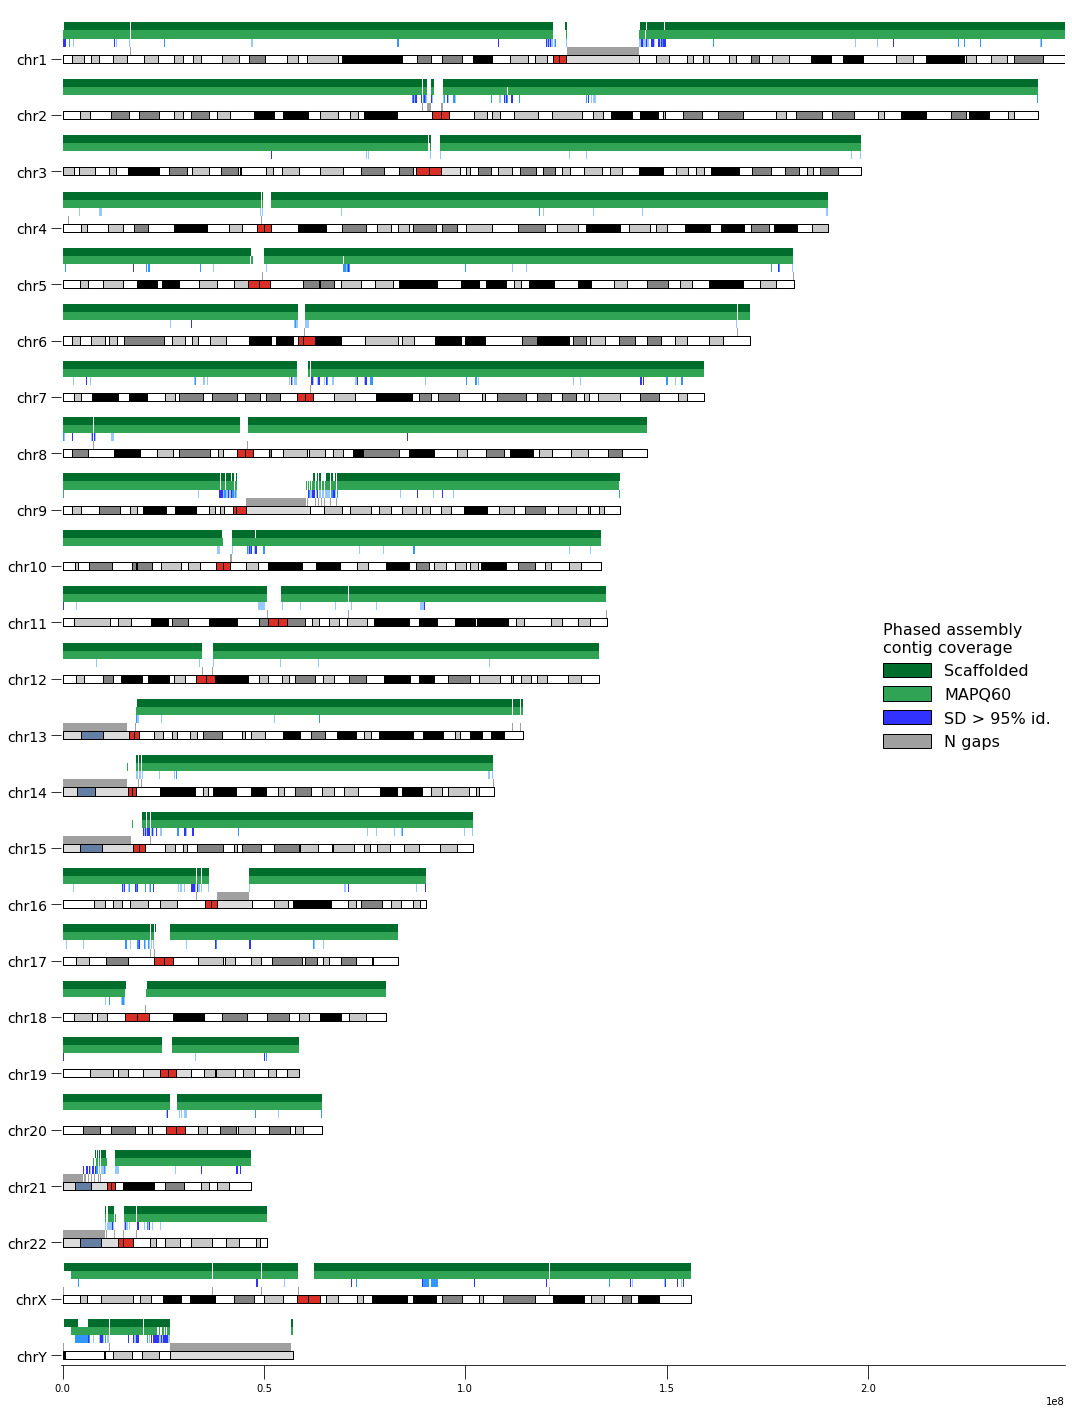

In [3]:
import pandas as pd
import os
import re
import importlib

import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt

def rgb_rel(rgb):
    return tuple([round(x/255, 3) for x in rgb])

def rel_rgb(rgb):
    return rgb_rel(rgb)

plot_aux_module = '/home/local/work/code/github/project-diploid-assembly/notebooks/aux_mods/plot_aux.py'
plot_aux_spec = importlib.util.spec_from_file_location("plot_aux", plot_aux_module)
plot_aux = importlib.util.module_from_spec(plot_aux_spec)
plot_aux_spec.loader.exec_module(plot_aux)

samples = plot_aux.load_sample_table()
hexcodes, rgbcodes, popmap = plot_aux.load_population_annotation()

prop = plot_aux.get_plot_property

pipeline_version = 'v12'

save_fig = True

# color definitions
white = (1, 1, 1)
lightest_blue = rel_rgb([150, 200, 255])
light_blue = rel_rgb([50, 150, 255])
dark_blue = rel_rgb([50, 50, 255])

mustard = rgb_rel([220, 200, 0])
medium_grey = rgb_rel([160, 160, 160])
purple = rgb_rel([150, 0, 150])
red = rgb_rel([255, 0, 0])
light_yellow = rgb_rel([255, 255, 150])
light_orange = rgb_rel([255, 180, 100])
red_hifi = red
red_clr = rgb_rel([155, 0, 0])

all60 = rel_rgb([0,109,44])  # darkest shade
any60 = rel_rgb([49,163,84])
any50 = rel_rgb([116,196,118])
any40 = rel_rgb([186,228,179])
any20 = rel_rgb([237,248,233])  # lightest shade

region_colors = {
    'Gap': medium_grey,
    'Variation': mustard,
    'Unknown': purple,
    'SD_98': light_blue,
    'SD_99': dark_blue,
    'UAB': red,
    'LCaln': light_orange
}


def color_segdups(region_score):
    if region_score < 950:
        return white
    elif 950 <= region_score < 980:
        return lightest_blue
    elif 980 <= region_score < 990:
        return light_blue
    elif 990 <= region_score < 1001:
        return dark_blue
    else:
        raise ValueError(region)

def load_annotation(file_path, color=None):

    df = pd.read_csv(file_path, sep='\t')
    if 'Issue_Type' in df:
        df['color'] = df['Issue_Type'].apply(lambda x: region_colors[x])
    elif color is not None:
        try:
            df['color'] = df['start'].apply(lambda x: color)
        except KeyError:
            df['color'] = df['chromStart'].apply(lambda x: color)
    elif 'chromStart' in df and color is None:
        df['color'] = df['score'].apply(color_segdups)
    else:
        assert color is not None, 'no color: {}'.format(file_path)
        df['color'] = df['start'].apply(lambda x: color)
    if 'end' in df:
        df['length'] = df['end'] - df['start']
    if 'chromEnd' in df:
        df['length'] = df['chromEnd'] - df['chromStart']
        df['start'] = df['chromStart']
        df['end'] = df['chromEnd']
        if color is None:
            df = df.loc[(df['score'] >= 950), :].copy()
    if '#chrom' in df:
        df['chrom'] = df['#chrom']
    return df

def load_cytogenetic_bands():
    # http://circos.ca/tutorials/lessons/2d_tracks/connectors/configuration
    gie_stain_rgb = {
        'gpos100': (0,0,0),
        'gpos': (0,0,0),
        'gpos75': (130,130,130),
        'gpos66': (160,160,160),
        'gpos50': (200,200,200),
        'gpos33': (210,210,210),
        'gpos25': (200,200,200),
        'gvar': (220,220,220),
        'gneg': (255,255,255),
        'acen': (217,47,39),
        'stalk': (100,127,164)
    }
    gie_stain_frac_rgb = {}
    for k, v in gie_stain_rgb.items():
        gie_stain_frac_rgb[k] = rgb_rel(v)
        path = '/home/local/work/code/github/project-diploid-assembly/annotation/grch38/known_regions'
        cytobands = 'ucsc_cytoband.bed'

        df = pd.read_csv(
            os.path.join(path, cytobands),
            header=0,
            names=['chrom', 'start', 'end', 'name', 'gieStain'],
            sep='\t'
        )
        df['length'] = df['end'] - df['start']
        df['color'] = df['gieStain'].apply(lambda x: rel_rgb(gie_stain_rgb[x]))

    return df

grch38_path = '/home/local/work/code/github/project-diploid-assembly/annotation/grch38'
issues = os.path.join(grch38_path, '20200723_GRCh38_p13_unresolved-issues.bed')
segdups = os.path.join(grch38_path, 'GRCh38_segdups.bed')
ngaps = os.path.join(grch38_path, 'GRCh38_ngaps.bed')

access_path = '/home/local/work/data/hgsvc/accessible_regions'

annotations = [
    (load_annotation(ngaps, medium_grey), 'N gaps'),
    (load_annotation(segdups), 'SD >98% id.'),
    
    (
        load_annotation(
            os.path.join(access_path, 'ctgcov_32smp_122XY_anyQ60.bed'),
            any60
        ),
        'Contigs (MQ60)'
    ),
        (
        load_annotation(
            os.path.join(access_path, 'scfcov_32smp_122XY_anyMedHigh.bed'),
            all60
        ),
        'Contigs (scaff.)'
    ),
]



# Figure stuff

width = 18
height = 25

fig, ax = plt.subplots(figsize=(width, height))

y_start = 0
primary_chroms = ['chr' + str(i) for i in range(1, 23)] + ['chrX' , 'chrY']
#primary_chroms = ['chr16']
y_labels = []
y_label_pos = []
legend_patches = []
max_plot = 0

cyto_bands = load_cytogenetic_bands()

for c in reversed(primary_chroms):
    y_labels.append(c)
    y_label_pos.append(y_start + 0.5)
    barh_xranges = []
    barh_colors = []
    for idx, band in cyto_bands.loc[cyto_bands['chrom'] == c, :].iterrows():
        x_min = band['start']
        x_width = band['length']
        x_max = x_min + x_width
        max_plot = max(max_plot, x_max)
        barh_xranges.append((x_min, x_width))
        barh_colors.append(band['color'])

    ax.broken_barh(
        barh_xranges,
        (y_start, 1),
        edgecolor='black',
        facecolors=barh_colors,
        zorder=10
    )
    y_start += 1

    # add annotations bottom to top
    for ann_table, ann_label in annotations:       
        barh_xranges = []
        barh_colors = []
        #y_labels.append(ann_label)
        #y_label_pos.append(y_start + 0.5)
        for idx, region in ann_table.loc[ann_table['chrom'] == c, :].iterrows():
            x_min = region['start']
            x_width = region['length']
            barh_xranges.append((x_min, x_width))
            if region['color'] is None:
                raise ValueError(ann_label)
            barh_colors.append(region['color'])
            
        ax.broken_barh(
            barh_xranges,
            (y_start, 1),
            edgecolor=None,
            facecolors=barh_colors
        )
        y_start += 1
    y_start += 2

legend_patches = []
legend_patches.append(
    patches.Patch(
        facecolor=all60,
        edgecolor='black',
        label='Scaffolded'
    )
)
legend_patches.append(
    patches.Patch(
        facecolor=any60,
        edgecolor='black',
        label='MAPQ60'
    )
)
legend_patches.append(
    patches.Patch(
        facecolor=dark_blue,
        edgecolor='black',
        label='SD > 95% id.'
    )
)
legend_patches.append(
    patches.Patch(
        facecolor=medium_grey,
        edgecolor='black',
        label='N gaps'
    )
)


legend = ax.legend(
    handles=legend_patches,
    loc='center right',
    handlelength=3,
    handleheight=1,
    prop={'size': 16},
    title='Phased assembly\ncontig coverage',
    title_fontsize=16,
    frameon=False
)
legend._legend_box.align = "left"

_ = ax.set_yticks(y_label_pos)
_ = ax.set_yticklabels(y_labels, fontsize=14)
#_ = ax.set_xticklabels([])
#_ = ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='y', which='major', length=10)
ax.tick_params(axis='x', which='major', length=10, size=14)

_ = ax.set_xlim(-500000, max_plot // 1e6 * 1e6 + 1e6)
_ = ax.set_ylim(-0.75, y_start)

if save_fig:
    
    low_res_dpi = prop('dpi_low_res')
    norm_res_dpi = prop('dpi_norm_res')

    out_path = '/home/local/work/data/hgsvc/figSX_panels/ideograms/figS14_PE_hap-assm-cov-ideogram'

    fig.savefig(
        out_path + '.{}dpi.png'.format(low_res_dpi),
        dpi=low_res_dpi,
        bbox_inches='tight'
    )
    
    fig.savefig(
        out_path + '.{}dpi.png'.format(norm_res_dpi),
        dpi=norm_res_dpi,
        bbox_inches='tight'
    )

    fig.savefig(
        out_path + '.svg',
        bbox_inches='tight'
    )